In [7]:
# Import necessary libraries
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import CategoricalAccuracy,Precision,Recall
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
# zipfile is used to extract the dataset from a zip file

!kaggle datasets download -d teresha/tomato-disease

Dataset URL: https://www.kaggle.com/datasets/teresha/tomato-disease
License(s): unknown
100% 1.12G/1.13G [00:12<00:00, 175MB/s]
100% 1.13G/1.13G [00:12<00:00, 96.8MB/s]


In [9]:
# Extract the dataset
!unzip "tomato-disease.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Tomato-dataset/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus(4664).JPG  
  inflating: Tomato-dataset/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus(4665).JPG  
  inflating: Tomato-dataset/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus(4666).JPG  
  inflating: Tomato-dataset/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus(4667).JPG  
  inflating: Tomato-dataset/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus(4668).JPG  
  inflating: Tomato-dataset/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus(4669).JPG  
  inflating: Tomato-dataset/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus(467).JPG  
  inflating: Tomato-dataset/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus(4670).JPG  
  inflating: Tomato-dataset/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus(4671).JPG  
  inflating: Tomato-dataset/Tomato_Yellow_Leaf_Curl_Virus/TomatoYellowCurlVirus(4672).JPG  
  inflating: Tomato-dataset/To

In [10]:
# Define the data directory
data_dir = "Tomato-dataset"

In [11]:
# Define the image extensions
image_extracts = ['jpeg', 'png', 'jpg', 'bmp']

In [12]:
# Loop through all the files in the directory
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class) # Get the path of the current class directory
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image) # Get the path of the current image

In [13]:
# Define the data directory
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 60387 files belonging to 10 classes.


In [14]:
# Get the class names
data_iterator = data.as_numpy_iterator()

In [15]:
# Get the first batch
batch = data_iterator.next()

In [16]:
# Check class names
class_names = data.class_names
print(f"Classes: {class_names}")

Classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Mosaic_virus', 'Tomato_Septoria_leafspot', 'Tomato_Spider_mites', 'Tomato_Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus']


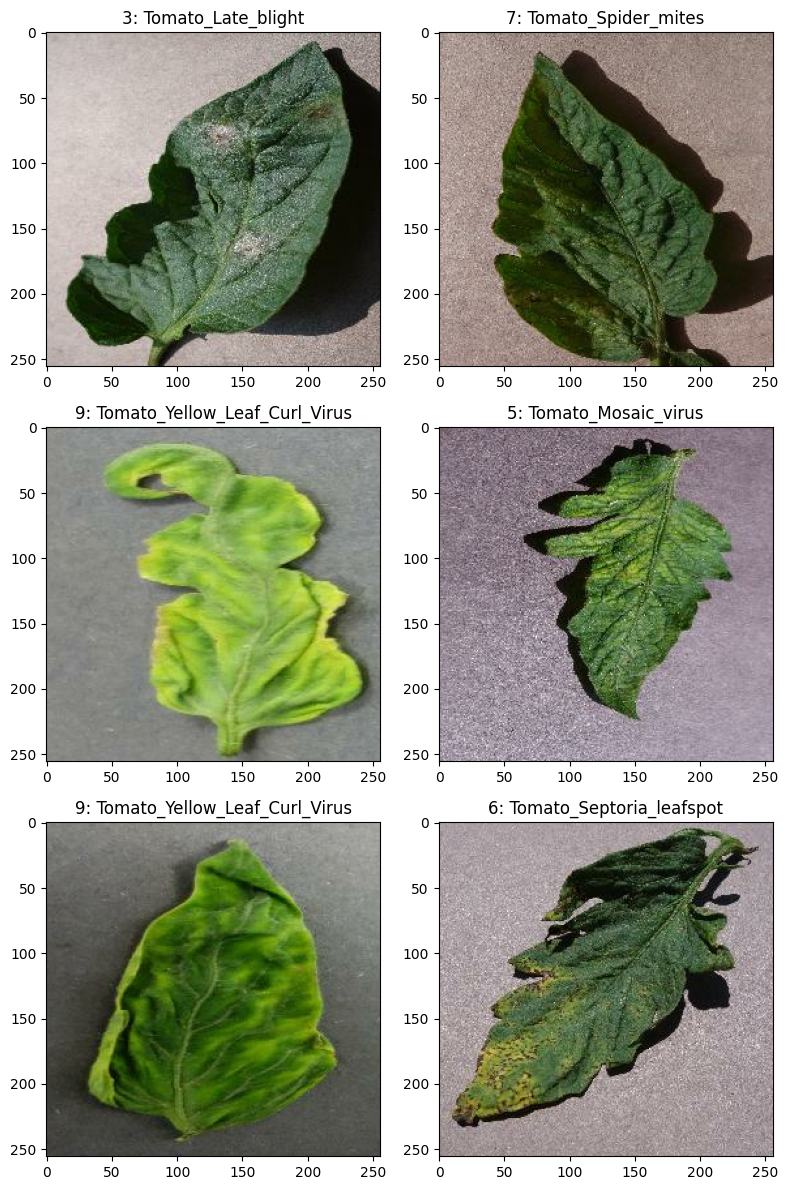

In [17]:
# Display the first 6 images
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))

# Display the first 6 images
for i, img in enumerate(batch[0][:6]):
    ax[i // 2, i % 2].imshow(img.astype(int))
    class_index = batch[1][i]
    class_label = class_names[class_index]
    ax[i // 2, i % 2].set_title(f'{class_index}: {class_label}')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()  # Display the plot

In [18]:
# Normalize the data
data=data.map(lambda x,y:(x/255,y))

In [19]:
# Define the total data points
total_data_points = len(data)
train_size = int(total_data_points * 0.7)
val_size = int(total_data_points * 0.2)
test_size = total_data_points - train_size - val_size



In [20]:
# Splitting the data into train, validation, and test sets
train = data.take(train_size)
validation = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [21]:
# Define the model
model=Sequential()
input_shape=(256,256,3)
num_classes=10
# Add the convolutional layers
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3), activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

# Add the fully connected layers
model.add(Flatten())
model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))  # New layer added
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax", kernel_regularizer=l2(0.001)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 6,321,610 (24.12 MB)

 Trainable params: 6,321,610 (24.12 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Define the tensorboard callback
logdir="logs"
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    verbose=1,
    restore_best_weights=True  # restores the weights of the best epoch
)

In [25]:
# Train the model
history = model.fit(
    train,
    epochs=50,
    validation_data=validation,
    callbacks=[tensorboard_callback]
)

Epoch 1/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 153s 103ms/step - accuracy: 0.2807 - loss: 2.2115 - val_accuracy: 0.7049 - val_loss: 1.0948
Epoch 2/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 133s 101ms/step - accuracy: 0.6872 - loss: 1.1300 - val_accuracy: 0.7512 - val_loss: 0.9463
Epoch 3/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 132s 100ms/step - accuracy: 0.7919 - loss: 0.8611 - val_accuracy: 0.8554 - val_loss: 0.6732
Epoch 4/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 132s 100ms/step - accuracy: 0.8345 - loss: 0.7353 - val_accuracy: 0.8418 - val_loss: 0.7409
Epoch 5/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 132s 100ms/step - accuracy: 0.8705 - loss: 0.6523 - val_accuracy: 0.9042 - val_loss: 0.5266
Epoch 6/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 137s 103ms/step - accuracy: 0.8940 - loss: 0.5737 - val_accuracy: 0.9255 - val_loss: 0.4746
Epoch 7/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 133s 101ms/step - accuracy: 0.8994 - loss: 0.5527 - val_accuracy: 0.9523 - val_loss: 0.3701
Epoch 8/50
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 137s 104ms/step - ac

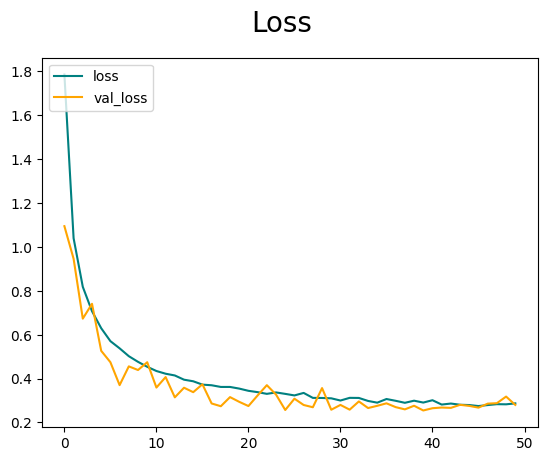

In [26]:
# Plot the training and validation loss
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

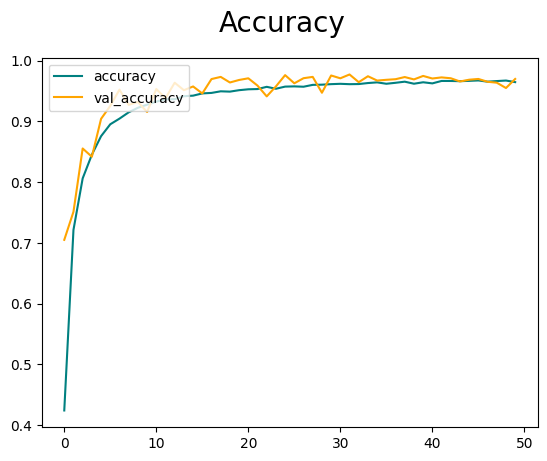

In [27]:
# Plot the training and validation accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [28]:
# Initialize metrics
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

# Loop through the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # One-hot encode the true labels
    y_one_hot = tf.keras.utils.to_categorical(y, num_classes=10)

    # Update states
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)

# Print results
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [29]:
# Save the model
model.save('tomato_cnn_model.h5')